Quenching a Random Product State
==================

First we'll set up a 20 qubit random product state, and a sparse heisenberg hamiltonian to evolve it with:

In [1]:
import quimb as qu

n = 20
H = qu.ham_heis(n, sparse=True)
psi0 = qu.rand_product_state(n)

We can do a few checks on the system like $\langle \psi | \psi \rangle$:

In [2]:
# check normalization
qu.expectation(psi0, psi0)

0.9999999999999987

and $\langle \psi | H | \psi \rangle$:

In [3]:
# find the initial energy
qu.expec(H, psi0)

0.3002436137794859

or $\langle \psi | H^2 | \psi \rangle$:

In [11]:
# find the initial variance in energy
Hpsi = H @ psi0
qu.expec(Hpsi, Hpsi)

11.30918741947443

Let's compare this to the total energy spectrum of the Hamiltonian ``H``:

In [12]:
%%time

en_low, en_high = qu.bound_spectrum(H)

print("Highest energy:", en_high)
print("Lowest energy:", en_low)

Highest energy: 4.749999999999985
Lowest energy: -8.682473334398967
CPU times: user 2min 48s, sys: 2min 16s, total: 5min 5s
Wall time: 45.9 s


From which we can infer that our initial state has roughly has overlap between many states in the centre of the spectrum.

Evolution
---------

Now let's set up some things we want to compute while we evolve with the hamiltonian. Namely the logarithmic negativity and mutual information between neighbouring qubits. Since we'll use the default adaptive integrating scheme, we'll return the current time as well:

In [13]:
def compute(t, pt):
    """Perform computation at time ``t`` with state ``pt``.
    """
    dims = [2] * n
    lns = [qu.logneg_subsys(pt, dims, i, i + 1) for i in range(n - 1)]
    mis = [qu.mutinf_subsys(pt, dims, i, i + 1) for i in range(n - 1)]
    return t, lns, mis

Set up the evolution with the initial state, hamiltonian and the compute dict:

In [14]:
evo = qu.Evolution(psi0, H, compute=compute, progbar=True)

Update the evolution to ``t=5``. The functions in ``compute`` will be called at each step the integrator uses. If we had set ``method='solve'`` or ``method='expm'``, we should use the generator ``evo.at_times(ts)`` to specify the time steps when computation takes place.

In [15]:
evo.update_to(5)

100%|##########| 100/100 [00:37<00:00,  2.66%/s]


We can extract the results of the computation from ``evo.results`` and plot them:

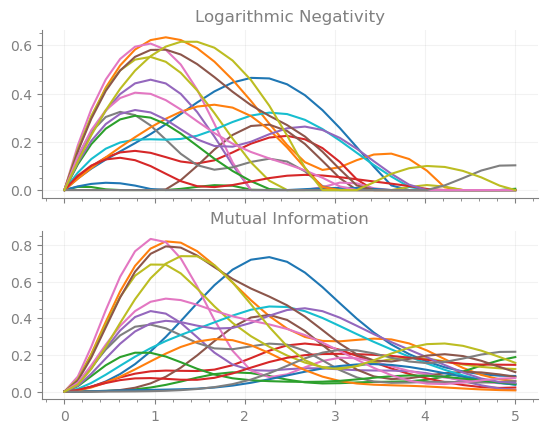

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

ts, lns, mis = zip(*evo.results)

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(ts, lns, '-');
    axs[0].set_title("Logarithmic Negativity")
    axs[1].plot(ts, mis, '-');
    axs[1].set_title("Mutual Information")

We can see that the classical correlations outlast the quantum correlations.

Finally, let's check that energy has been conserved in the current state at ``t=5``:

In [20]:
qu.expec(H, evo.pt)

0.3002436962453416